### IMPORT PACKAGES

In [ ]:
from gymnasium.envs.registration import register
import gymnasium as gym
from stable_baselines3 import *

# from stable_baselines3 import A2C
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement
import torch as th

import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
# from gymnasium.utils import seeding
from enum import Enum
import pandas as pd
import math
import matplotlib.pyplot as plt
from copy import deepcopy
import gymnasium as gym
from gymnasium import spaces
from gymnasium.utils import seeding
from enum import Enum
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("C:/Users/da2343/Projects/robust_algo_trader/data/EURUSD/trades_EURUSD_H1_2011_2022.csv")

In [ ]:
df

In [ ]:
class TradeUpdateEnv(gym.Env):
    def __init__(self,  df, window_size, frame_bound):
        assert len(frame_bound) == 2
        assert frame_bound[0] >= window_size
        assert frame_bound[1] > frame_bound[0]
        
        self.frame_bound = frame_bound
        
        # self.seed()
        self.df = df
        self.window_size = window_size
        self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])

        # spaces
        self.observation_space = spaces.Box(low=-100, 
                                            high=100,
                                            shape=self.shape, 
                                            dtype=np.float64)
        self.action_space = spaces.Discrete(2)

        # episode
        self._start_tick = self.window_size
        self._current_tick = self._start_tick
        self._last_final_tick = len(self.signal_features) - 1
        self._end_tick = None
        self._terminated = None
        self._truncated = False
        self._total_reward = 0
        self._total_profit = None
        self._prev_loss = False


    def _process_data(self):
        features_df = self.df[["position", "RSI", "ATR", "ADX", "AROON_Oscillator", "MFI","label"]]
        # features_df = self.df[["position", "RSI", "label"]]
        features_df['label'] = features_df['label'].shift(1)
        features_df = features_df.iloc[1:]
        features_np = features_df.to_numpy()
        _start_index = self.frame_bound[0] - self.window_size
        _end_index = self.frame_bound[1]
        signal_features = features_np[_start_index:_end_index]
        return signal_features

    def _get_observation(self):
        _start_index = self._current_tick - self.window_size + 1
        _end_index = self._current_tick + 1
        _obs = self.signal_features[_start_index:_end_index]
        self._current_tick += 1
        return _obs


    def reset(self, seed=None, options=None):
        super().reset(seed=1)
        self._terminated = False
        self._truncated = False
        self._prev_loss = False
        # self._current_tick = np.random.randint(
        #     self._start_tick, len(self.signal_features) - 50
        # )
        self._end_tick = self._current_tick + 30
        observation = self._get_observation()
        info = dict(total_reward = self._total_reward)
        return observation, info


    def step(self, action):
        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward
        info = dict(total_reward = self._total_reward)
        observation = self._get_observation()
        # set done flag to True if episode ended because of tick limit
        if self._current_tick == self._end_tick:
            self._terminated = True
        # set truncated flag to True if episode ended because of tick limit
        if self._current_tick == self._last_final_tick:
            self._truncated = True
            # reset the current tick to the start tick
            self._current_tick = self._start_tick
        return observation, step_reward, self._terminated, self._truncated, info


    def _calculate_reward(self, action):
        step_reward = 0
        label_action = self.signal_features[self._current_tick+1][6]
        # label_action = self.signal_features[self._current_tick+1][2]
        # if action == label_action:
        #     step_reward += 1
    
        if action == 1 and label_action == 0:
            step_reward += -1
            if self._prev_loss == True:
                step_reward += -2
            self._prev_loss = True
            print("lost")
        else:
            self._prev_loss = False
        # else:
            # step_reward += 0.1
            # print("nothing")
            
        if action == 1 and label_action == 1:
            step_reward += 1.5
            print("won")
            
        return step_reward

env = TradeUpdateEnv(
       df = deepcopy(df),
       window_size = 3,
       frame_bound = (4, 3000)
)

In [ ]:
# Save a checkpoint every 1000 steps
checkpoint_callback = CheckpointCallback(
  save_freq=10_000,
  save_path="./log_10_17/",
  name_prefix="trade_drl_model",
  save_replay_buffer=True,
  save_vecnormalize=True,
)


In [ ]:




# policy_kwargs = dict(activation_fn=th.nn.ReLU,
#                      net_arch=dict(pi=[128, 128], vf=[128, 128]))

# policy_kwargs = dict(
#     net_arch=[256, 64, 64], # The number and size of the hidden layers
#     activation_fn=th.nn.Tanh, # The activation function
#     lstm=50 # The size of the LSTM cell
# )

policy_kwargs=dict(
    net_arch=[256, 128, 128, 64],
    activation_fn=th.nn.Tanh,
          # lstm_hidden_size=64,
      )

model = RecurrentPPO('MlpLstmPolicy', 
                     env, 
                     verbose=1, 
                    gamma=0.01,
                    gae_lambda = 0.9,
                    #gamma=0,
                    #n_epochs=1000,
                    seed=1,                 
                    #policy_kwargs = policy_kwargs, 
                    device="cuda",
                    tensorboard_log="./trade_env_tensorboard/")
# model.policy
model.learn(total_timesteps=1_000_000_000,  
            log_interval=10, 
            tb_log_name="trade_drl_experiment",
            callback=checkpoint_callback,
            )

In [ ]:
from sb3_contrib import RecurrentPPO

# Load the model from a zip file
saved_model = RecurrentPPO.load("C:/Users/da2343/Projects/robust_algo_trader/drl/logs/trade_drl_model_3580000_steps.zip")
saved_model

# set the env of the saved_model
saved_model.set_env(env, force_reset=False)

In [ ]:
# Save a checkpoint every 1000 steps
checkpoint_callback = CheckpointCallback(
  save_freq=10_000,
  save_path="./logs/",
  name_prefix="trade_drl_model_B",
  save_replay_buffer=True,
  save_vecnormalize=True,
)

saved_model.learn(total_timesteps=1_000_000_000,  
            log_interval=10, 
            tb_log_name="trade_drl_experiment",
            callback=checkpoint_callback,
            )

In [ ]:

import matplotlib.pyplot as plt
# df = pd.read_csv("/Users/newuser/Projects/robust-algo-trader/envs/trades_2021.csv")
env = TradeUpdateEnv(
       df = deepcopy(df),
       window_size = 3,
       frame_bound = (3000, 5000)
)
observation, info = env.reset()
episode_count = 0
step_count = 1
step_reward_list = []
print("got here")
lstm_states = None
num_envs = 1
# Episode start signals are used to reset the lstm states
episode_starts = np.ones((num_envs,), dtype=bool)

while True:
    action, lstm_states = model.predict(observation,state=lstm_states, 
                                        episode_start=episode_starts, 
                                        deterministic=True)
    # action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    # print(action)
    print(reward)
    step_reward_list.append({
        "step": step_count,
        "test_reward": reward,
    })
    step_count += 1
    
    # print("info:", info)
    if terminated:
        episode_count += 1
    # observation, reward, done, info = env.step(action)
    # env.render()
    if truncated:
        print("info:", info)
        break
print("episode_count:", episode_count)

test_reward_df = pd.DataFrame(step_reward_list) 
# add cumulative reward column
test_reward_df["test_cum_reward"] = test_reward_df["test_reward"].cumsum()

import matplotlib.pyplot as plt
# plot the cumulative reward against the step
plt.plot(test_reward_df["step"], test_reward_df["test_cum_reward"])
# show labels
plt.xlabel("step")
plt.ylabel("test_cum_reward")


In [ ]:

import matplotlib.pyplot as plt
# df = pd.read_csv("/Users/newuser/Projects/robust-algo-trader/envs/trades_2021.csv")

from sb3_contrib import RecurrentPPO

# Load the model from a zip file
model = RecurrentPPO.load("C:/Users/da2343/Projects/robust_algo_trader/drl/log_10_17/trade_drl_model_44040000_steps.zip")

env = TradeUpdateEnv(
       df = deepcopy(df),
       window_size = 3,
    #    frame_bound = (4, 3000)
       frame_bound = (4, 2004)
)
observation, info = env.reset()
episode_count = 0
step_count = 1
step_reward_list = []
print("got here")
lstm_states = None
num_envs = 1
# Episode start signals are used to reset the lstm states
episode_starts = np.ones((num_envs,), dtype=bool)

while True:
    action, lstm_states = model.predict(observation,state=lstm_states, 
                                        episode_start=episode_starts, 
                                        deterministic=True)
    # action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    print(reward)
    # if reward != 0:
    step_reward_list.append({
        "step": step_count,
        "train_reward": reward,
    })
    step_count += 1
    
    # print("info:", info)
    if terminated:
        episode_count += 1
    # observation, reward, done, info = env.step(action)
    # env.render()
    if truncated:
        print("info:", info)
        break
print("episode_count:", episode_count)

train_reward_df = pd.DataFrame(step_reward_list) 
# add cumulative reward column
train_reward_df["train_cum_reward"] = train_reward_df["train_reward"].cumsum()

import matplotlib.pyplot as plt
# plot the cumulative reward against the step
plt.plot(train_reward_df["step"], train_reward_df["train_cum_reward"])
# show labels
plt.xlabel("step")
plt.ylabel("train_cum_reward")

In [9]:
train_test_reward_df = pd.merge(train_reward_df, test_reward_df, on="step", how="outer")
train_test_reward_df
# choose first 1000 rows
# train_test_reward_df = train_test_reward_df.iloc[40:50]

# plot a graph of train_cum_reward and test_cum_reward against the step 
# give the train_cum_reward and test_cum_reward different colors
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is called df





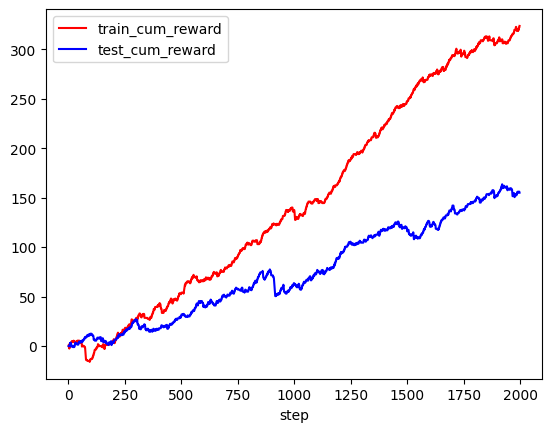

In [10]:
train_test_reward_df.plot(x="step", y=["train_cum_reward", "test_cum_reward"], color=["red", "blue"])
plt.show()
# save the plot as a png file
#plt.savefig("train_test_reward.png")